# Handwritten digit classification via transfer learning

... to decode the MNIST 784 dataset. This dataset contains a subset of 70,000 size-normalized and centered hand written digits. Previously a convolutional neural network was built with 99.6% accuracy.

...

In [269]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ModelCheckpoint
import os
import pickle

In [270]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning'

### Preprocessing data

In [271]:
#Loading MNIST_784 dataset from OpenML
mnist = fetch_openml('mnist_784', as_frame = False, parser='auto') 
X,y = mnist.data.reshape(-1,28,28,1), mnist.target.reshape(-1,1)
y = y.astype(np.int64)

In [272]:
#rescaling X
print('X range before rescaling:')
print(round(X[0].min(),2), round(X[0].max(),2))

X = X/127.5-1
print('X range after rescaling')
print(round(X[0].min(),2), round(X[0].max(),2))
print(f'X mean: {round(X.mean(),2)}')
print(f' X std: {round(X.std(),2)}')


X range before rescaling:
0 255
X range after rescaling
-1.0 1.0
X mean: -0.74
 X std: 0.62


In [273]:
#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

Image shape before:
(70000, 28, 28, 1)
Image shape after:
(70000, 28, 28, 3)

Checking Image:


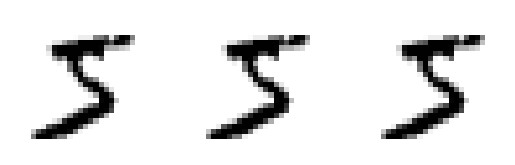

In [274]:
#repeating gray scale image in 3 channel format for compatability with three channel format 
#of the pre-trained network

print('Image shape before:')
print(X.shape)  
X_rgb = np.repeat(X,3,axis=-1)
print('Image shape after:')
print(X_rgb.shape)

print('\nChecking Image:')
#checking repeat image 
for n in range(3):
    ax = plt.subplot(1,3,n+1)
    show_num(X_rgb[0][:,:,n])

In [275]:
#Making test and train sets
X_train, y_train, X_valid, y_valid, X_test, y_test = X_rgb[:60000], y[:60000],X_rgb[60000:65000],y[60000:65000],X_rgb[65000:],y[65000:]

#temporary 
X_train = X_train[:1000]
y_train = y_train[:1000]
X_valid = X_valid[:100]
y_valid = y_valid[:100]


train_data = (X_train, y_train, X_valid, y_valid)

### Building and training transfer learning models

In [276]:
#function for creating transfer learning model

def build(t_model, input_size):
    #creates transfer model
    transfer_model = t_model(include_top=False, input_shape=(input_size,input_size,3),weights='imagenet')
    transfer_model.trainable = False #freezes model 
    #note: setting trainable to false also sets training to false for BN layers in tf version 2.0 and above

    #creates model with fully connected layers
    print('Building model...')
    inputs = tf.keras.Input(shape=(28,28,3), name='Input')
    x = tf.keras.layers.Resizing(input_size, input_size)(inputs)
    x = transfer_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')(x)
    model = tf.keras.Model(inputs, outputs)

    print(model.summary())

    
    #compile model 
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.Adam(0.001),
            metrics = ['accuracy'])
    

    return(model)

In [277]:
def train_FC(model, train_data, iters):
    #creating callback to save best weights 
    weight_name = 'weights_'+str(model.layers[2].name)+'_fc.h5'
    save_weights = ModelCheckpoint(weight_name, save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True)

    #training top layers
    print('Training top layers...')
    history = model.fit(train_data[0], train_data[1], validation_data=(train_data[2:]), epochs = iters[0],callbacks=[save_weights, early_stopping])

    #saving weights
    #model.save_weights(weight_name)
    
    return(model, history)

In [278]:
def fine_tune(model, train_data, iters):
    print('Fine tuning all layers...')
    
    #unfreezing transfer model
    model.layers[2].trainable = True 
    #print(str(model.layers[2].name),str(model.layers[2].trainable))

    #Checking that BN layers are in inference mode and all layers are trainable
    for layer in model.layers[2].layers: 
        if (isinstance(layer, tf.keras.layers.BatchNormalization)):
            layer.trainable = False
        else: assert layer.trainable == True

    #compiling model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(1e-5),
        metrics = ['accuracy'])

    #creatubg callbacks 
    weight_name = 'weights_'+str(model.layers[2].name)+'_ft.h5'
    save_weights = ModelCheckpoint(weight_name, save_best_only=True, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True)

    #training model
    history = model.fit(train_data[0], train_data[1], validation_data = (train_data[2:]), epochs = iters[1],callbacks=[save_weights,early_stopping])

    #saving weights
    #model.save_weights(weight_name)

    return(model, history)

In [279]:
def build_and_train(t_model, input_size, train_data, iters):
    model = build(t_model, input_size)

    model, history = train_FC(model, train_data, iters)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fc_epochs = len(acc)

    model, history = fine_tune(model, train_data, iters)
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

    scores = (acc, val_acc, loss, val_loss, fc_epochs)
    #pickles scores
    pickle_name = t_model.__name__+'_scores.pkl'
    pickle.dump(scores, open(pickle_name, 'wb'))

    return(model,scores)
    

In [280]:
def predict(model, test_data):
    y_pred = model.predict(test_data[0]).argmax(axis=1)
    return accuracy_score(test_data[1],y_pred)

## Models

In [281]:
#fully connected training iterations
fc_iter = 1

#fine tuning traiing iterations
ft_iter = 1

iters = (fc_iter, ft_iter)

In [282]:
scores = []
model_names = ['Resnet50','InceptionV3','Mobilenet']

In [283]:
resnet_model, resnet_score = build_and_train(ResNet50,32,train_data,iters)
scores.append(resnet_score)

Building model...
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_28 (Resizing)      (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_28 (Flatten)        (None, 2048)              0         
                                                                 
 dense_84 (Dense)            (None, 128)               262272    
                                                                 
 dropout_56 (Dropout)        (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 64) 

In [284]:
inception_model, inception_score = build_and_train(InceptionV3,75,train_data,iters)
scores.append(inception_score)

Building model...
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_29 (Resizing)      (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_29 (Flatten)        (None, 2048)              0         
                                                                 
 dense_87 (Dense)            (None, 128)               262272    
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 dense_88 (Dense)            (None, 64) 

In [285]:
mobilenet_model, mobilenet_score = build_and_train(MobileNet,32,train_data,iters)
scores.append(mobilenet_score)

Building model...
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_30 (Resizing)      (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 1024)              0         
                                                                 
 dense_90 (Dense)            (None, 128)               131200    
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                        

### Model Performance

In [286]:
def model_scores(score):
    acc = score[0]
    val_acc = score[1]
    loss = score[2]
    val_loss = score[3]
    training_epochs = score[4]
    return acc, val_acc, loss, val_loss, training_epochs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


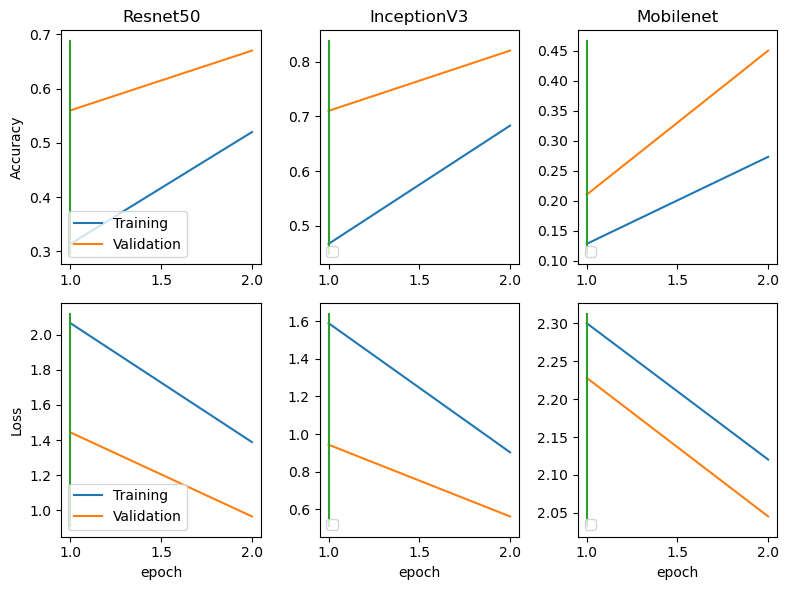

In [287]:
print(len(scores))

count = 1
plt.figure(figsize=(8, 6))
for score in scores:
    acc, val_acc, loss, val_loss, training_epochs = model_scores(score)
    x_range = range(1,len(acc)+1)

    #selecting legend entry 
    if count == 1:
        label_train = 'Training'
        label_val= 'Validation'
    else: 
        label_train = None
        label_val = None

    plt.subplot(2, 3, count)
    plt.plot(x_range, acc, label=label_train)
    plt.plot(x_range, val_acc, label=label_val)
    #plt.ylim([0.8, 1])
    plt.plot([training_epochs, training_epochs],plt.ylim(), label=None)
    if count == 1:
        plt.ylabel('Accuracy')

    plt.legend(loc='lower left')
    plt.title(model_names[count-1])

    plt.subplot(2, 3, count+3)
    plt.plot(x_range, loss, label=label_train)
    plt.plot(x_range, val_loss, label=label_val)
    #plt.ylim([0, 1.0])
    plt.plot([training_epochs, training_epochs],plt.ylim(), label=None)
    plt.legend(loc='lower left')
    plt.xlabel('epoch')
    if count == 1:
        plt.ylabel('Loss')
    
    count +=1

plt.tight_layout()

In [288]:
file = open('ResNet50_scores.pkl', 'rb')
data = pickle.load(file)
data

([0.3140000104904175, 0.5199999809265137],
 [0.5600000023841858, 0.6700000166893005],
 [2.0653605461120605, 1.3881409168243408],
 [1.4432319402694702, 0.9649348258972168],
 1)